Het voorspellen van de bondprijs alleen op basis van historische waarde van de bond is waarschijnlijk nooit erg succesvol. Voor een betere voorspelling zullen we 'leading indicatoren' moeten hebben. Indicatoren die iets zeggen waar de markt naar toe gaat.

Voor dit onderzoek richt ik mij op deze indicatoren:
- Remaining Duration
- Theoretical Bond Prices
- Inflation curve
- Referentie bond (Germany 10 years)
- Term Spread
- Bid Offer Spread

In [3]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

if IS_COLAB:
    !git clone https://github.com/Merijn68/BondTrading.git    
    %pip install -q "ray[tune]" bayesian-optimization
    %pip install loguru tensorflow-addons
    %cd BondTrading

In [9]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "..")

import math
from src.data import make_dataset
from src.models import base_model,evaluate
from src.visualization import visualize
from src.features import build_features
from pathlib import Path
import pandas as pd
from src.models import window

import tensorflow as tf
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as tfl
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
if IS_COLAB:
    df_bonds = make_dataset.get_bond_data(path = Path("data/raw/price.csv"))
    df_bonds = make_dataset.impute_bonds(df_bonds)
    df_price = make_dataset.get_price(path = Path("data/raw/price.csv"))
    df_price = make_dataset.impute_price(df_price)
    df_bp = make_dataset.join_price(df_bonds,df_price )
    df_bp = make_dataset.build_features.add_duration(df_bp)
else:
    df_bp = make_dataset.read_pkl('bp', path = Path("data/processed/")) 
   
isin = "NL0011220108" # 10 Years NL Bond, maturity 2025 0.25% coupon
df_isin = df_bp[df_bp['reference_identifier'] == isin]


2022-01-24 17:37:04.605 | INFO     | src.data.make_dataset:read_pkl:400 - Load preprocessed bp data


In [16]:
# Add theoretically calculated bond price 

if IS_COLAB:
    df_yield = make_dataset.get_yield()
    df_yield = make_dataset.impute_yield(df_yield)  
else:
    df_yield = make_dataset.read_pkl('yield', path = Path("data/processed/")) 
df_isin_ytm = make_dataset.join_ytm(df_isin, df_yield)
df_isin_ytm = build_features.add_estimated_bond_price(df_isin_ytm)


2022-01-24 17:38:45.575 | INFO     | src.data.make_dataset:read_pkl:400 - Load preprocessed yield data


<AxesSubplot:xlabel='rate_dt'>

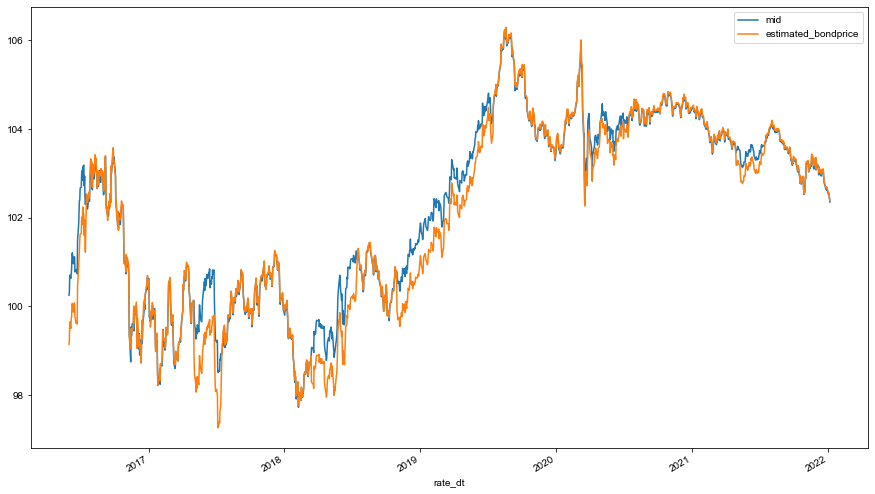

In [18]:
df_isin_ytm.plot(x = 'rate_dt',y = ['mid','estimated_bondprice'], figsize = (15,9))

<AxesSubplot:xlabel='rate_dt'>

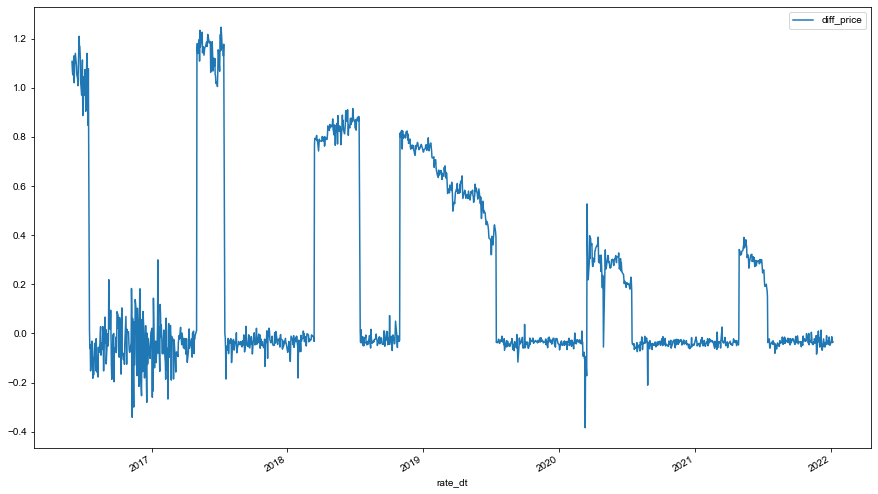

In [20]:
df_isin_ytm['diff_price'] = df_isin_ytm['mid'] - df_isin_ytm['estimated_bondprice']
df_isin_ytm.plot(x = 'rate_dt',y = 'diff_price', figsize = (15,9))

In [72]:
# Add Term Spread and Bid-Offer spread
df_bpy = make_dataset.join_yield(df_isin_ytm, df_yield)
df_bpy = build_features.add_term_spread(df_bpy)
df_bpy = build_features.add_bid_offer_spread(df_bpy)

2022-01-24 18:36:58.253 | INFO     | src.features.build_features:add_term_spread:64 - Add term spread...
2022-01-24 18:36:58.256 | INFO     | src.features.build_features:add_bid_offer_spread:75 - Add bid offer spread...


In [73]:
df_bpy.columns

Index(['reference_identifier', 'rate_dt', 'ccy', 'mid', 'lastday', 'country',
       'bond_ext_name', 'issue_dt', 'first_coupon_date', 'mature_dt', 'isin',
       'issuer_name', 'coupon_frq', 'coupon', 'tot_issue', 'cfi_code',
       'issue_rating', 'bond_duration', 'remain_duration', 'time', 'ytm',
       'estimated_bondprice', 'diff_price', 'y_bid1', 'y_offer1', 'y_bid2',
       'y_offer2', 'y_bid3', 'y_offer3', 'y_bid4', 'y_offer4', 'y_bid5',
       'y_offer5', 'y_bid6', 'y_offer6', 'y_bid7', 'y_offer7', 'y_bid8',
       'y_offer8', 'y_bid9', 'y_offer9', 'y_bid10', 'y_offer10', 'y_bid15',
       'y_offer15', 'y_bid20', 'y_offer20', 'y_bid30', 'y_offer30',
       'term_spread', 'y_spread_1', 'y_spread_2', 'y_spread_3', 'y_spread_4',
       'y_spread_5', 'y_spread_6', 'y_spread_7', 'y_spread_8', 'y_spread_9',
       'y_spread_10', 'y_spread_15', 'y_spread_20', 'y_spread_30'],
      dtype='object')

In [92]:
# Add inflation
if IS_COLAB:
    df_inflation = make_dataset.get_inflation()
    df_inflation = make_dataset.impute_inflation(df_inflation)    
else:
    df_inflation = make_dataset.read_pkl('inflation', path = Path("data/processed/")) 
df_bpyi = make_dataset.join_infl(df_bpy, df_inflation, country = 'Germany')

2022-01-24 18:54:58.051 | INFO     | src.data.make_dataset:read_pkl:415 - Load preprocessed inflation data


In [94]:
len(df_bpyi)

1419

In [95]:
dfbpyi.columns

Index(['reference_identifier', 'rate_dt', 'ccy', 'mid', 'lastday', 'country',
       'bond_ext_name', 'issue_dt', 'first_coupon_date', 'mature_dt', 'isin',
       'issuer_name', 'coupon_frq', 'coupon', 'tot_issue', 'cfi_code',
       'issue_rating', 'bond_duration', 'remain_duration', 'time', 'ytm',
       'estimated_bondprice', 'diff_price', 'y_bid1', 'y_offer1', 'y_bid2',
       'y_offer2', 'y_bid3', 'y_offer3', 'y_bid4', 'y_offer4', 'y_bid5',
       'y_offer5', 'y_bid6', 'y_offer6', 'y_bid7', 'y_offer7', 'y_bid8',
       'y_offer8', 'y_bid9', 'y_offer9', 'y_bid10', 'y_offer10', 'y_bid15',
       'y_offer15', 'y_bid20', 'y_offer20', 'y_bid30', 'y_offer30',
       'term_spread', 'y_spread_1', 'y_spread_2', 'y_spread_3', 'y_spread_4',
       'y_spread_5', 'y_spread_6', 'y_spread_7', 'y_spread_8', 'y_spread_9',
       'y_spread_10', 'y_spread_15', 'y_spread_20', 'y_spread_30', '1 YEAR',
       '10 YEARS', '15 YEARS', '2 YEARS', '20 YEARS', '25 YEARS', '3 YEARS',
       '30 YEARS', '4 YE

In [96]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df_bpyi = df_bpyi[['rate_dt','mid','estimated_bondprice','term_spread','y_spread_10','10 YEARS']]
df_bpyi.columns = ['rate_dt','mid','estimated_bondprice','term_spread','yield_spread_10','inflation_10y']

In [97]:
df_bpyi

,rate_dt,mid,estimated_bondprice,term_spread,yield_spread_10,inflation_10y
0,2016-06-01,100.251,99.143517,1.22495,0.691,1.5100
1,2016-06-02,100.319,99.246441,1.19705,0.668,1.5050
2,2016-06-03,100.702,99.649445,1.15855,0.578,1.4925
3,2016-06-06,100.632,99.501990,1.19130,0.611,1.4975
4,2016-06-07,100.751,99.730541,1.15510,0.560,1.5000
...,...,...,...,...,...,...
1415,2021-12-17,103.034,103.089160,0.77350,-0.490,2.2200
1416,2021-12-20,103.070,103.100442,0.82000,-0.462,2.2250
1417,2021-12-21,102.951,102.959839,0.87600,-0.345,2.2875
1418,2021-12-22,102.820,102.863777,0.90100,-0.290,2.3550


In [99]:

df_bpyi = df_bpyi.set_index('rate_dt')
df_bpyi = df_bpyi.sort_index()

series = df_bpyi['mid']
split = math.floor(len(series) * .70)

# Train test split
train = df_bpyi[:split]
test = df_bpyi[split:]

scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)



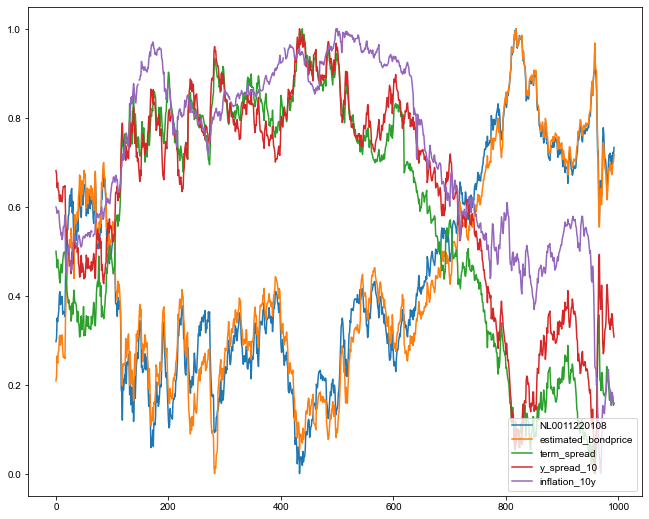

In [102]:
# ax.plot(train)

plt.rcParams["figure.figsize"] = [11, 9]
line1, = plt.plot(train[:,0], label=isin)
line2, = plt.plot(train[:,1], label="estimated_bondprice")
line3, = plt.plot(train[:,2], label="term_spread")
line4, = plt.plot(train[:,3], label="y_spread_10")
line4, = plt.plot(train[:,4], label="inflation_10y")
leg = plt.legend(loc='lower right')


De correlatie tussen deze items is echt ongeloofelijk. Ik zie nog niet hoe dit mogelijk is. Kan de spread tussen bid en ask prijzen, de spread tussen 2 years en 10 years bonds en de inflatie een zelfde trend aanhouden als de ontwikkeling van de marktwaarde? Dat lijkt te mooi om waar te zijn.

In [38]:
visualize.timeplot(train, test, figurepath = Path("reports/figures"), name = 'timeseries traintestsplit')

AttributeError: 'numpy.ndarray' object has no attribute 'index'

<Figure size 720x432 with 0 Axes>

In [41]:
split = math.floor(len(df_isin) * .70)

# Train test split
train = df_isin[:split]
test = df_isin[split:]
tmin = train.min()
tmax = train.max()
train=(train-tmin)/(tmax-tmin)
test =(test- tmin)/(tmax-tmin)

<AxesSubplot:xlabel='rate_dt'>

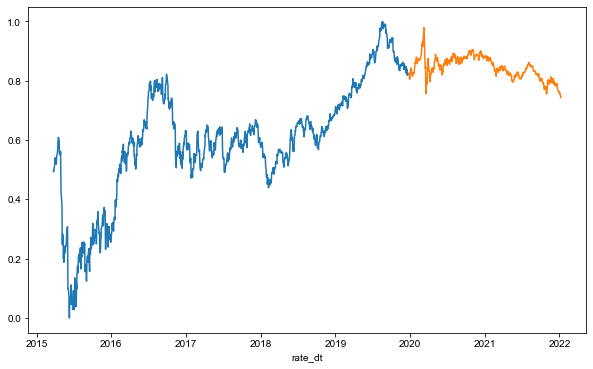

In [8]:
visualize.timeplot(train['mid'], test['mid'], figurepath = Path("reports/figures"), name = 'timeseries traintestsplit')

In [42]:
# Create a windowed dataset from the data
window_size = 32 
batch_size = 32
shuffle_buffer = 2
horizon = 10
train_set = window.windowed_dataset_from_df(train, window_size, batch_size, shuffle_buffer, horizon=horizon)
valid_set = window.windowed_dataset_from_df(test, window_size, batch_size, shuffle_buffer, horizon=horizon)

2022-01-24 11:47:48.543 | INFO     | src.models.window:windowed_dataset_from_df:12 - Split windowed dataset window_size = 32, batch_size =  32, shuffle_buffer =  2, horizon =  10
2022-01-24 11:47:48.575 | INFO     | src.models.window:windowed_dataset_from_df:12 - Split windowed dataset window_size = 32, batch_size =  32, shuffle_buffer =  2, horizon =  10


We have 1 features!
We have 1 features!


In [44]:
y, yhat = base_model.naivepredict(train.iloc[:, 0].values)
norm = evaluate.mae(y, yhat)
evaluate.mae(y, yhat), evaluate.mse(y, yhat), evaluate.mase(y, yhat)

(0.012229328185583187, 0.00031282996870604906, 0.9994767468190888)

In [51]:
# Mean Absolute Error - for horizon
norm = base_model.calc_mae_for_horizon(train_set, horizon)
print(norm)
smae = evaluate.ScaledMAE(scale=norm)

0.027770603838435614


In [52]:
x, y = next(iter(train_set))
x.shape, y.shape

(TensorShape([32, 32, 2]), TensorShape([32, 10]))

In [ ]:
result = {}
models = {}

In [56]:
model = Sequential([                  
        tfl.SimpleRNN(1),
        tfl.Dense(horizon)
    ])
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
lr = 1e-2
model.compile(loss="mse", optimizer=Adam(learning_rate=lr), metrics=["mae", smae])
model.fit(train_set,epochs=200, validation_data=valid_set, callbacks=[early_stop], verbose=1)

Epoch 1/200
37/37 [==============================] - 8s 128ms/step - loss: 0.2136 - mae: 0.4342 - smae: 15.6359 - val_loss: 0.2367 - val_mae: 0.4842 - val_smae: 17.4352
Epoch 2/200
37/37 [==============================] - 4s 109ms/step - loss: 0.0510 - mae: 0.1942 - smae: 6.9947 - val_loss: 0.0913 - val_mae: 0.2986 - val_smae: 10.7518
Epoch 3/200
37/37 [==============================] - 4s 111ms/step - loss: 0.0358 - mae: 0.1418 - smae: 5.1070 - val_loss: 0.0536 - val_mae: 0.2211 - val_smae: 7.9611
Epoch 4/200
37/37 [==============================] - 4s 114ms/step - loss: 0.0383 - mae: 0.1439 - smae: 5.1825 - val_loss: 0.0391 - val_mae: 0.1803 - val_smae: 6.4915
Epoch 5/200
37/37 [==============================] - 4s 114ms/step - loss: 0.0364 - mae: 0.1388 - smae: 4.9966 - val_loss: 0.0251 - val_mae: 0.1358 - val_smae: 4.8901
Epoch 6/200
37/37 [==============================] - 4s 112ms/step - loss: 0.0264 - mae: 0.1104 - smae: 3.9742 - val_loss: 0.0090 - val_mae: 0.0734 - val_smae: 2.

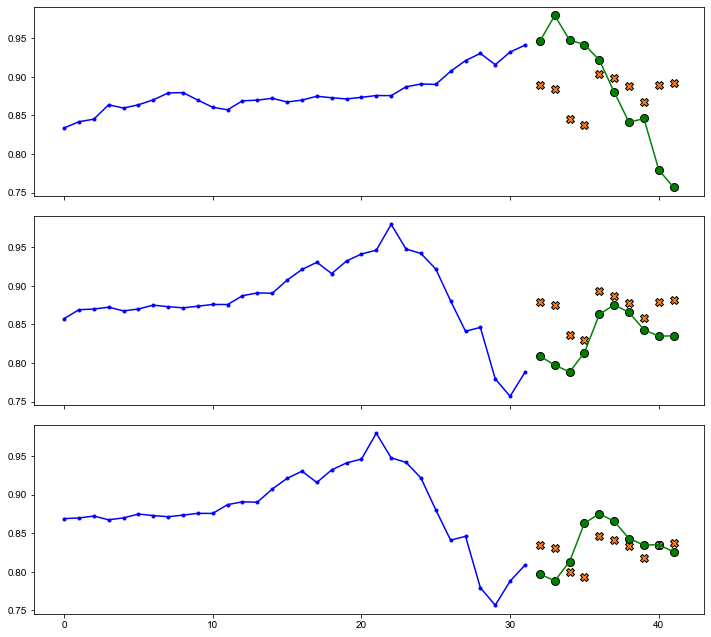

In [74]:
fig = visualize.plot_example(
    valid_set, 
    window_size = window_size, 
    horizon = horizon, 
    examples = 3, 
    model = model,
    figurepath = Path("reports/figures"), 
    name = 'example base model')